In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

2025-04-10 09:00:01.091393: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Epoch 1/100
5/5 [==============================] - 1s 4ms/step - loss: 0.3181
Epoch 2/100
5/5 [==============================] - 0s 4ms/step - loss: 0.2397
Epoch 3/100
5/5 [==============================] - 0s 4ms/step - loss: 0.1783
Epoch 4/100
5/5 [==============================] - 0s 4ms/step - loss: 0.1331
Epoch 5/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0953
Epoch 6/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0643
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0510
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0422
Epoch 9/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0310
Epoch 10/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0196
Epoch 11/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0114
Epoch 12/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0040
Epoch 13/100
5/5 [==============================] - 0s 4ms/st

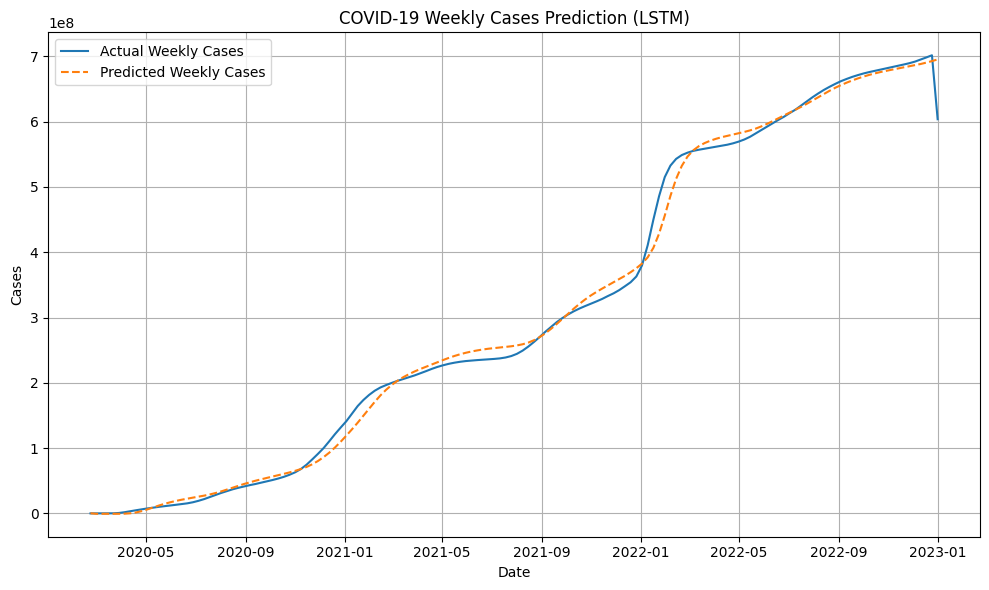

In [2]:
df = pd.read_csv("cleaned_US_cases_and_deaths.csv", parse_dates=['Date'])

df = df[~df['Date'].dt.year.eq(2023)]

weekly_df = df.groupby(pd.Grouper(key='Date', freq='W'))[['Cases', 'Deaths', 'Lat', 'Long_', 'Population']].sum().reset_index()

# normalize case values
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(weekly_df[['Cases', 'Deaths', 'Lat', 'Long_', 'Population']])

# create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length][0])
    return np.array(X), np.array(y)

seq_length = 4  # number of weeks to look back
X, y = create_sequences(features_scaled, seq_length)
X = X.reshape((X.shape[0], X.shape[1], features_scaled.shape[1]))

# define LSTM 
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, X.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# train model
model.fit(X, y, epochs=100, verbose=1)

y_pred = model.predict(X)

y_pred_full = np.zeros((len(y_pred), features_scaled.shape[1]))
y_pred_full[:, 0] = y_pred.flatten()  # only 'Cases' column

y_true_full = np.zeros((len(y), features_scaled.shape[1]))
y_true_full[:, 0] = y.flatten()

y_pred_inverse = scaler.inverse_transform(y_pred_full)[:, 0]
y_true_inverse = scaler.inverse_transform(y_true_full)[:, 0]


# plotting
plt.figure(figsize=(10, 6))
plt.plot(weekly_df['Date'][seq_length:], y_true_inverse, label='Actual Weekly Cases')
plt.plot(weekly_df['Date'][seq_length:], y_pred_inverse, label='Predicted Weekly Cases', linestyle='--')
plt.title("COVID-19 Weekly Cases Prediction (LSTM)")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(y_true_inverse, y_pred_inverse)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_inverse, y_pred_inverse)
r2 = r2_score(y_true_inverse, y_pred_inverse)
n = len(y_true_inverse)
p = 1  # one predictor 
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print("Model Evaluation Metrics:")
print(f"📉 MSE: {mse:.2f}")
print(f"📈 RMSE: {rmse:.2f}")
print(f"📊 MAE: {mae:.2f}")
print(f"🧠 R² Score: {r2:.4f}  (1.0 = perfect prediction)")
print(f"🧮 Adjusted R² Score: {adjusted_r2:.4f}")

Model Evaluation Metrics:
📉 MSE: 224459469237712.09
📈 RMSE: 14981971.47
📊 MAE: 9539237.58
🧠 R² Score: 0.9961  (1.0 = perfect prediction)
🧮 Adjusted R² Score: 0.9961


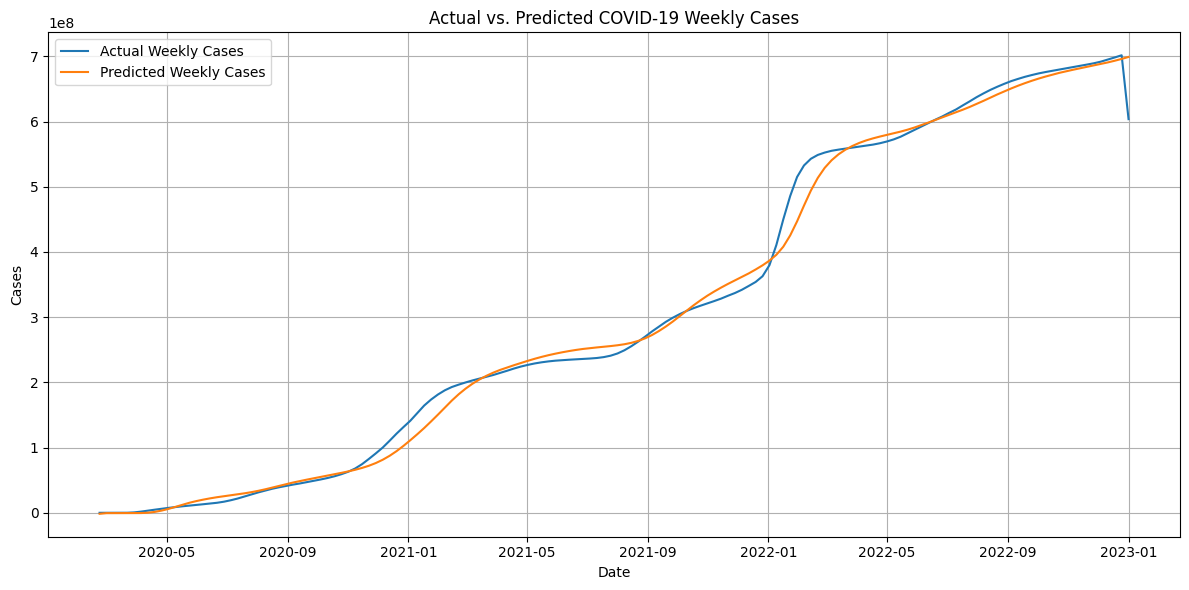

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(weekly_df['Date'][seq_length:], y_true_inverse, label='Actual Weekly Cases')
plt.plot(weekly_df['Date'][seq_length:], y_pred_inverse, label='Predicted Weekly Cases')
plt.title("Actual vs. Predicted COVID-19 Weekly Cases")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

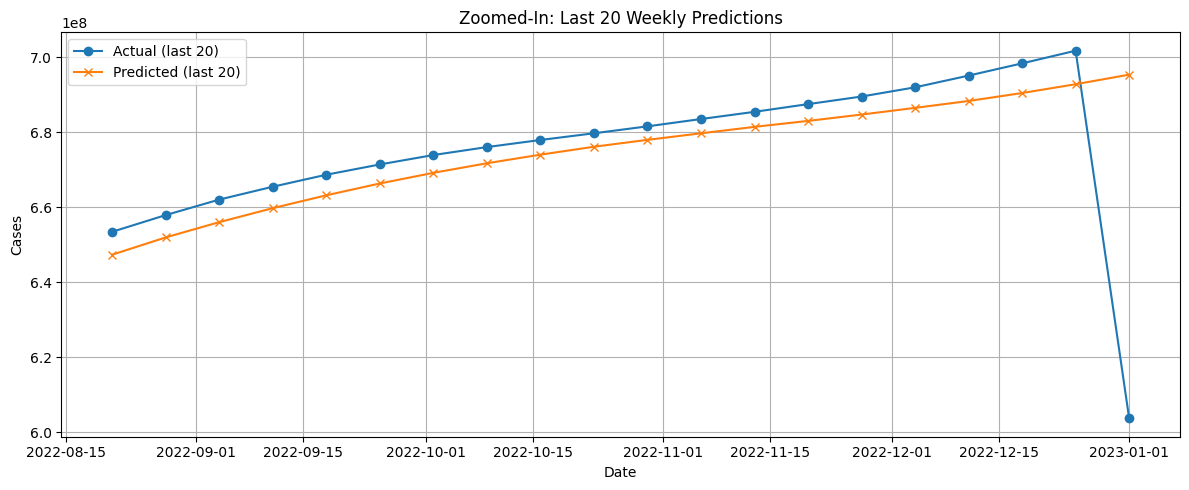

In [4]:
plt.figure(figsize=(12, 5))
plt.plot(weekly_df['Date'][seq_length:][-20:], y_true_inverse[-20:], marker='o', label='Actual (last 20)')
plt.plot(weekly_df['Date'][seq_length:][-20:], y_pred_inverse[-20:], marker='x', label='Predicted (last 20)')
plt.title("Zoomed-In: Last 20 Weekly Predictions")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Input shape: (150, 4, 5)
Epoch 1/100
5/5 [==============================] - 1s 4ms/step - loss: 0.3823
Epoch 2/100
5/5 [==============================] - 0s 4ms/step - loss: 0.2755
Epoch 3/100
5/5 [==============================] - 0s 4ms/step - loss: 0.1885
Epoch 4/100
5/5 [==============================] - 0s 4ms/step - loss: 0.1233
Epoch 5/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0728
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0402
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0286
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0278
Epoch 9/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0255
Epoch 10/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0173
Epoch 11/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0103
Epoch 12/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0075
Epoch 13/100
5/5 [==================

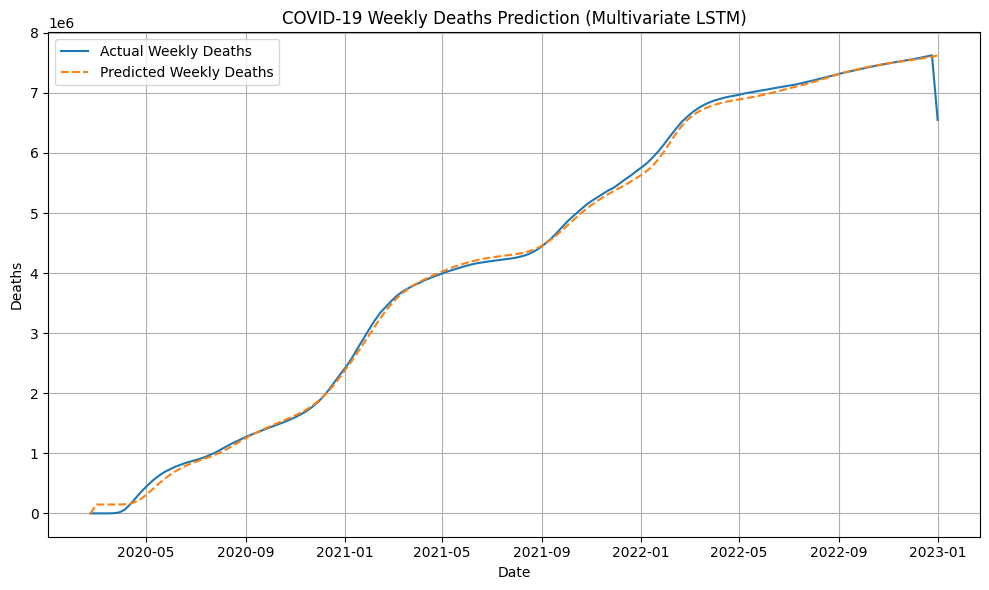

In [5]:
# load and preprocess
df = pd.read_csv("cleaned_US_cases_and_deaths.csv", parse_dates=['Date'])
df = df[~df['Date'].dt.year.eq(2023)]

# group by week and sum all features
weekly_df = df.groupby(pd.Grouper(key='Date', freq='W'))[['Cases', 'Deaths', 'Lat', 'Long_', 'Population']].sum().reset_index()

# normalize features
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(weekly_df[['Cases', 'Deaths', 'Lat', 'Long_', 'Population']])

def create_multivariate_sequences(data, seq_length, target_index=1):  # 1 = 'Deaths'
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, target_index])  # target: 'Deaths'
    return np.array(X), np.array(y)

seq_length = 4
X, y = create_multivariate_sequences(features_scaled, seq_length)

# X shape: (samples, time steps, features)
print("Input shape:", X.shape)

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, X.shape[2])))
model.add(Dense(1))  # predicting just 'Deaths'
model.compile(optimizer='adam', loss='mse')

model.fit(X, y, epochs=100, verbose=1)

y_pred = model.predict(X)

y_pred_full = np.zeros((len(y_pred), features_scaled.shape[1]))
y_pred_full[:, 1] = y_pred.flatten()  # 1 = 'Deaths'

y_true_full = np.zeros((len(y), features_scaled.shape[1]))
y_true_full[:, 1] = y

y_pred_inverse = scaler.inverse_transform(y_pred_full)[:, 1]
y_true_inverse = scaler.inverse_transform(y_true_full)[:, 1]

# plot
plt.figure(figsize=(10, 6))
plt.plot(weekly_df['Date'][seq_length:], y_true_inverse, label='Actual Weekly Deaths')
plt.plot(weekly_df['Date'][seq_length:], y_pred_inverse, label='Predicted Weekly Deaths', linestyle='--')
plt.title("COVID-19 Weekly Deaths Prediction (Multivariate LSTM)")
plt.xlabel("Date")
plt.ylabel("Deaths")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
d_mse = mean_squared_error(y_true_inverse, y_pred_inverse)
d_rmse = np.sqrt(mse)
d_mae = mean_absolute_error(y_true_inverse, y_pred_inverse)
d_r2 = r2_score(y_true_inverse, y_pred_inverse)
d_n = len(y_true_inverse)
d_p = 1  # one predictor 
d_adjusted_r2 = 1 - (1 - d_r2) * (d_n - 1) / (d_n - d_p - 1)
print("Model Evaluation Metrics:")
print(f"📉 MSE: {d_mse:.2f}")
print(f"📈 RMSE: {d_rmse:.2f}")
print(f"📊 MAE: {d_mae:.2f}")
print(f"🧠 R² Score: {d_r2:.4f}  (1.0 = perfect prediction)")
print(f"🧮 Adjusted R² Score: {d_adjusted_r2:.4f}")

Model Evaluation Metrics:
📉 MSE: 11800575042.68
📈 RMSE: 14981971.47
📊 MAE: 58798.26
🧠 R² Score: 0.9981  (1.0 = perfect prediction)
🧮 Adjusted R² Score: 0.9981


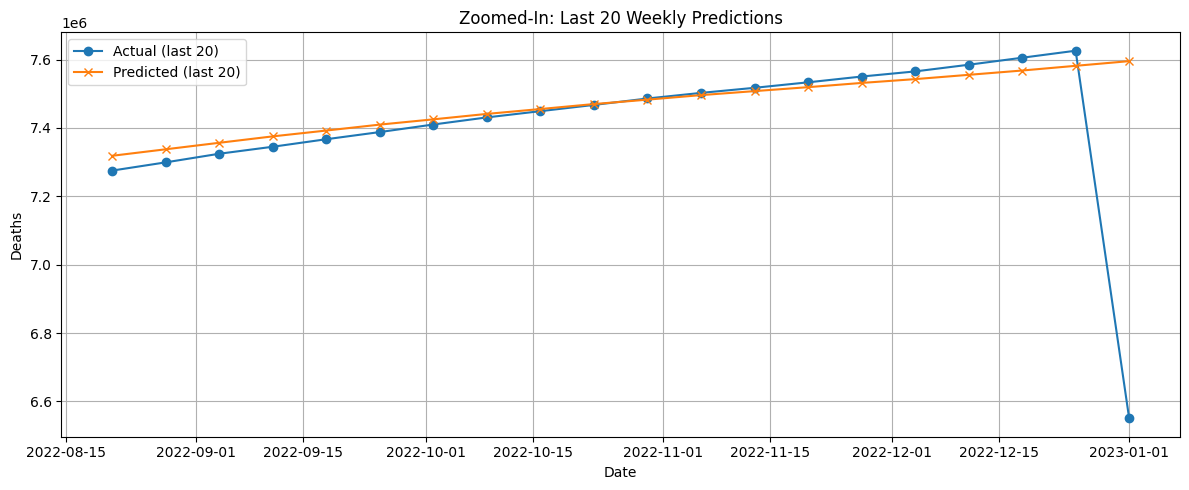

In [13]:
plt.figure(figsize=(12, 5))
plt.plot(weekly_df['Date'][seq_length:][-20:], y_true_inverse[-20:], marker='o', label='Actual (last 20)')
plt.plot(weekly_df['Date'][seq_length:][-20:], y_pred_inverse[-20:], marker='x', label='Predicted (last 20)')
plt.title("Zoomed-In: Last 20 Weekly Predictions")
plt.xlabel("Date")
plt.ylabel("Deaths")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
df.head()

,Date,UID,iso2,iso3,code3,Province_State,Country_Region,Lat,Long_,Combined_Key,Cases,Population,Deaths
0,2020-01-22,84040005,US,USA,840,Oklahoma,US,34.373666,-96.038025,"Atoka, Oklahoma, US",0,13758,0
1,2020-01-22,84004009,US,USA,840,Arizona,US,32.931669,-109.888218,"Graham, Arizona, US",0,38837,0
2,2020-01-22,84046065,US,USA,840,South Dakota,US,44.390915,-99.996611,"Hughes, South Dakota, US",0,17526,0
3,2020-01-22,84038085,US,USA,840,North Dakota,US,46.113233,-101.044015,"Sioux, North Dakota, US",0,4230,0
4,2020-01-22,84006063,US,USA,840,California,US,40.003560,-120.839524,"Plumas, California, US",0,18807,0
